#### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import nltk
import string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/sobuj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sobuj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Load the data

In [2]:
df = pd.read_csv("dataset/Resume.csv")
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [3]:
# drop unnecessary columns
df = df.drop(['ID', 'Resume_html'], axis=1)
# rename columns
df = df.rename(columns={'Resume_str': 'Resume'})
# move category column to the front
df = df[['Category', 'Resume']]
df.head()

,Category,Resume
0,HR,HR ADMINISTRATOR/MARKETING ASSOCIATE\...
1,HR,"HR SPECIALIST, US HR OPERATIONS ..."
2,HR,HR DIRECTOR Summary Over 2...
3,HR,HR SPECIALIST Summary Dedica...
4,HR,HR MANAGER Skill Highlights ...


### Data Exploration and Preprocessing

#### Checking length of the list of resumes

In [4]:
df.shape

(2484, 2)

> *There are 2484 resumes in the dataset.*

#### Checking the info for the columns

In [5]:
# check the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2484 non-null   object
 1   Resume    2484 non-null   object
dtypes: object(2)
memory usage: 38.9+ KB


In [6]:
# check for null values
df.isna().sum()

Category    0
Resume      0
dtype: int64

In [7]:
df.describe()

,Category,Resume
count,2484,2484
unique,24,2482
top,INFORMATION-TECHNOLOGY,STOREKEEPER II Professional Sum...
freq,120,2


In [8]:
# check unique categories
df['Category'].unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [9]:
print("Total number of available jobs:", df.Category.nunique())

Total number of available jobs: 24


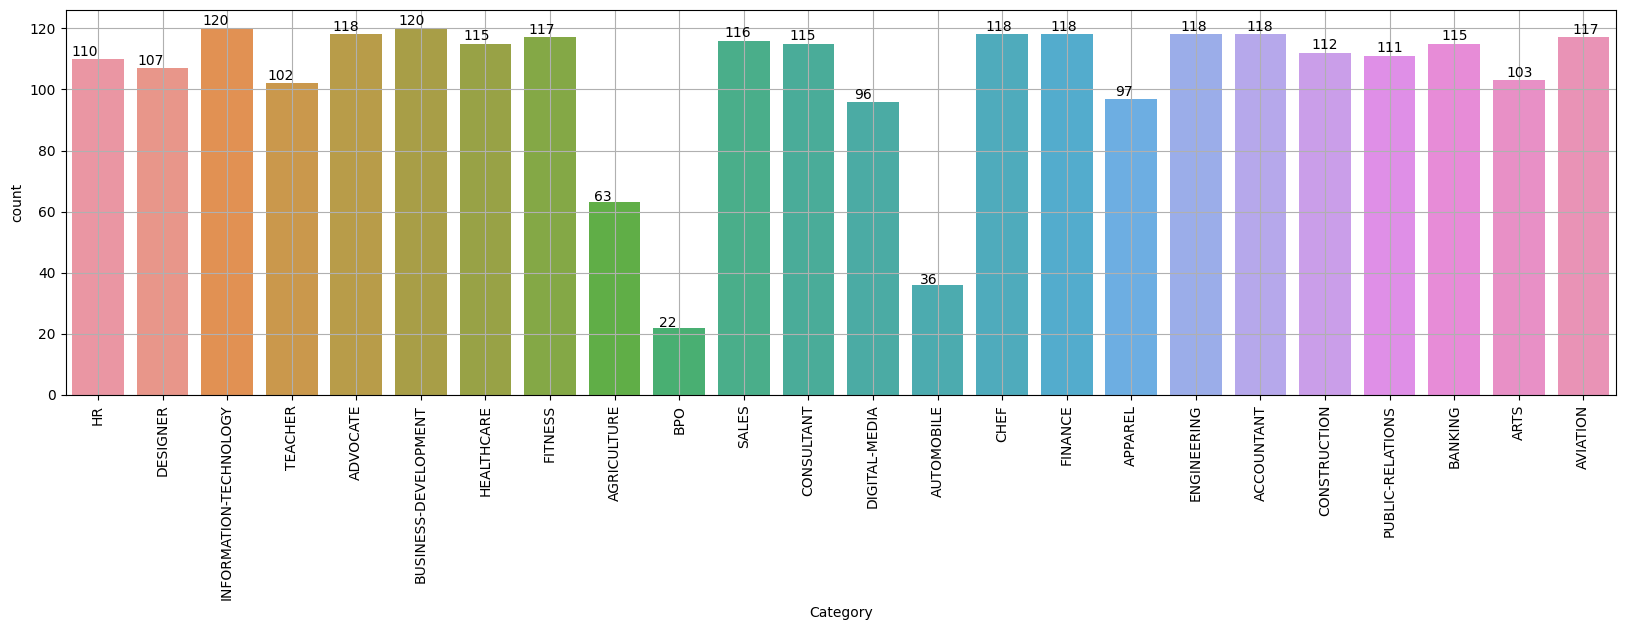

In [10]:
# showing the distribution of the categories
plt.figure(figsize=(20, 5))
plt.xticks(rotation=90)
ax = sns.countplot(x="Category", data=df)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() * 1.01, p.get_height() * 1.01))

plt.grid()
plt.show()

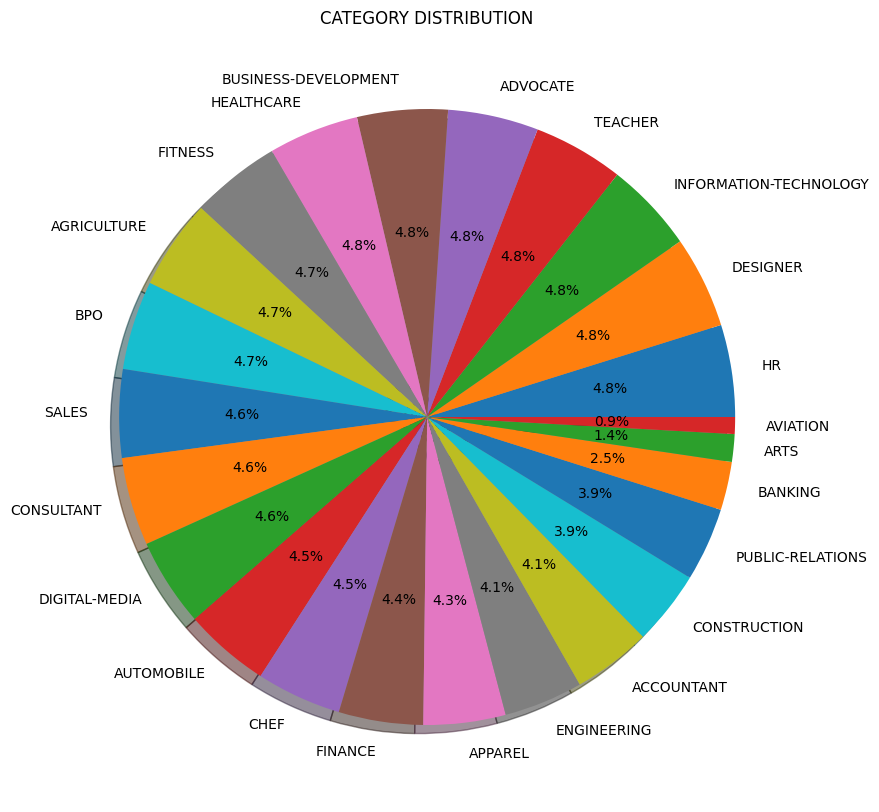

In [11]:
from matplotlib.gridspec import GridSpec
targetCounts = df['Category'].value_counts()
targetLabels  = df['Category'].unique()
# Make square figures and axes
plt.figure(1, figsize=(22,22))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True)
plt.show()

#### Preprocessing

In [31]:
import re
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('\d+', '', resumeText)  # remove digits
    resumeText = re.sub('[^a-zA-Z\s]', '', resumeText)  # remove special characters (excluding whitespace and letters)
    resumeText = re.sub('@\S+', ' ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]', r' ', resumeText)  # remove non-ascii characters
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    resumeText = resumeText.lower()  # convert to lowercase
    return resumeText
    
df['cleaned_resume'] = df.Resume.apply(lambda x: cleanResume(x))
df.head()

,Category,Resume,cleaned_resume
0,0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,hr administratormarketing associate hr admini...
1,0,"HR SPECIALIST, US HR OPERATIONS ...",hr specialist us hr operations summary versat...
2,0,HR DIRECTOR Summary Over 2...,hr director summary over years experience in ...
3,0,HR SPECIALIST Summary Dedica...,hr specialist summary dedicated driven and dy...
4,0,HR MANAGER Skill Highlights ...,hr manager skill highlights hr skills hr depa...


In [13]:
df['cleaned_resume'][0]

' hr administratormarketing associate hr administrator summary dedicated customer service manager with years of experience in hospitality and customer service management respected builder and leader of customerfocused teams strives to instill a shared enthusiastic commitment to customer service highlights focused on customer satisfaction team management marketing savvy conflict resolution techniques training and development skilled multitasker client relations specialist a omplishments missouri dot supervisor training certification certified by ihg in customer loyalty and marketing by segment hilton worldwide general manager training certification a omplished trainer for cross server hospitality systems such as hilton onq micros opera pms fidelio opera reservation system ors holidex completed courses and seminars in customer service sales strategies inventory control loss prevention safety time management leadership and performance assessment experience hr administratormarketing associ

#### Most common words from Resume

In [14]:
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = df['Resume'].values
cleanedSentences = ""
for records in Sentences:
    cleanedText = cleanResume(records)
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(10)
print(mostcommon)

[('state', 16063), ('city', 15045), ('company', 14663), ('management', 11996), ('name', 11737), ('sales', 8124), ('skills', 7695), ('business', 7686), ('customer', 7607), ('new', 6336)]


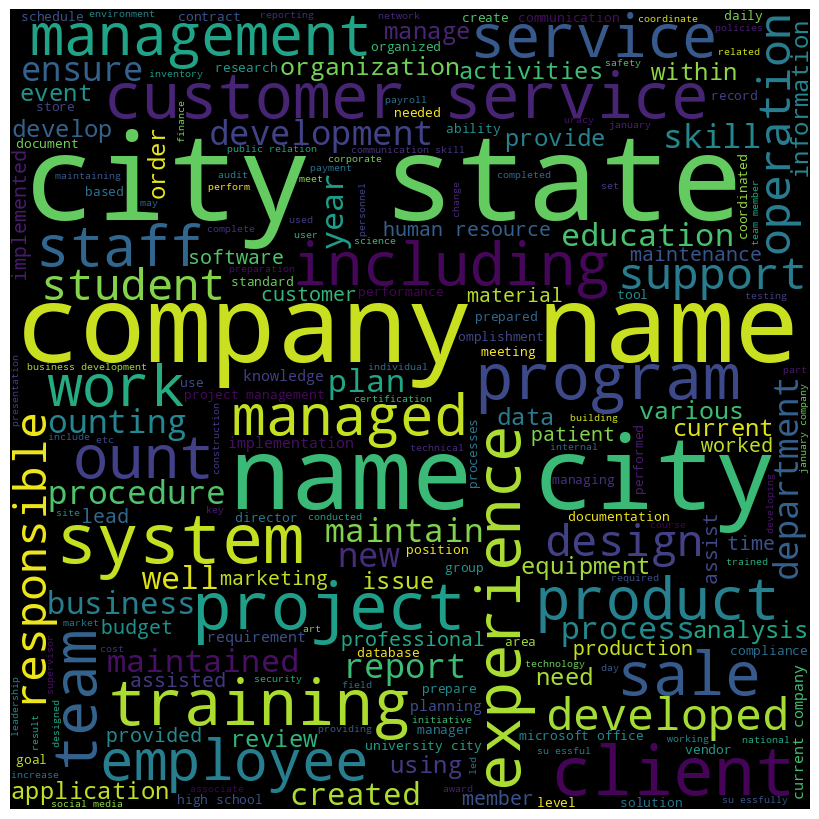

In [30]:
# Define a function to plot word cloud
def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width=800, height=800, 
                                   background_color='black', 
                                   stopwords=None,
                                   min_font_size=10).generate(text) 
             
    plt.figure(figsize=(8, 8), facecolor=None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad=0) 
    plt.show()

text = " ".join(i for i in df.cleaned_resume)
    
plot_word_cloud(text)

#### Encoding Target Variable

In [28]:
labels_dict = {}

for idx, label in enumerate(df.Category.unique()):
    labels_dict[label] = idx

labels_dict

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23}

In [16]:
df.Category = df.Category.apply(func=lambda x: labels_dict[x])
df.Category = df.Category.astype(np.int64)

In [17]:
df.Category.value_counts() # understaning the label encoder

Category
2     120
5     120
15    118
4     118
18    118
17    118
14    118
23    117
7     117
10    116
21    115
6     115
11    115
19    112
20    111
0     110
1     107
22    103
3     102
16     97
12     96
8      63
13     36
9      22
Name: count, dtype: int64

### Building model

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

cleaned_resumes = df['cleaned_resume'].values
categories = df['Category'].values

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english', max_features = 3000)

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_resumes)

print("Feature extraction completed ...")

Feature extraction completed ...


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC  # You can replace this with your choice of ML model

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(tfidf_matrix, categories, random_state=1, test_size=0.2, shuffle=True, stratify=categories)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=1, test_size=0.5, shuffle=True, stratify=y_temp)

# Print the shapes of the sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1987, 3000)
Validation set shape: (248, 3000)
Test set shape: (249, 3000)


In [35]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [36]:
clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)
# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set: {:.2f}'.format(clf.score(X_val, y_val)))

Accuracy of KNeighbors Classifier on training set: 0.68
Accuracy of KNeighbors Classifier on test set: 0.48


In [23]:
print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_val, y_val_pred)))


 Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.70      0.70        10
           2       0.50      0.50      0.50        12
           3       0.60      0.60      0.60        10
           4       0.43      0.25      0.32        12
           5       0.28      0.42      0.33        12
           6       0.38      0.45      0.42        11
           7       0.64      0.58      0.61        12
           8       1.00      0.29      0.44         7
           9       0.00      0.00      0.00         2
          10       0.14      0.09      0.11        11
          11       0.20      0.18      0.19        11
          12       0.55      0.60      0.57        10
          13       0.50      0.25      0.33         4
          14       0.70      0.58      0.64        12
          15       0.57      0.33      0.

In [37]:
import torch
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(set(categories)))

# Prepare DataLoader for validation
batch_size = 16
val_data = TensorDataset(X_val['input_ids'], X_val['attention_mask'])
val_dataloader = DataLoader(val_data, batch_size=batch_size)

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)  # Adjust learning rate as needed

# Evaluation
model.eval()
val_preds = []
with torch.no_grad():
    for batch in val_dataloader:
        outputs = model(input_ids=batch[0], attention_mask=batch[1])
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)
        val_preds.extend(preds.tolist())

# Convert predictions back to category labels
val_pred_labels = [classes[pred] for pred in val_preds]

# Evaluate the model
print(classification_report(y_val, val_pred_labels))


ModuleNotFoundError: No module named 'torch'